# Imports and Settings

In [143]:
import itertools
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, f_oneway
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler

#from tpot import TPOTClassifier

In [144]:
# Enable diagrams to visualize pipelines
# Set output from transformers to DataFrames
from sklearn import set_config
set_config(display="diagram", transform_output="pandas")

In [145]:
# Enable imports from parent directory
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)

In [146]:
from graph_utils import *

# Load Data

In [147]:
df = pd.read_csv("data/census_us.csv")

In [148]:
df.sample(5)

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income
9224,50,Private,149770.0,Masters,Never-married,Prof-specialty,Unmarried,White,Female,0.0,0.0,40.0,<=50K
22656,40,Private,70761.0,Assoc-acdm,Never-married,Tech-support,Not-in-family,Black,Male,0.0,0.0,40.0,<=50K
4815,31,Private,101562.0,HS-grad,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0.0,0.0,55.0,<=50K
429,41,Private,193626.0,HS-grad,Married-spouse-absent,Craft-repair,Unmarried,White,Female,0.0,0.0,40.0,<=50K
21704,37,State-gov,252939.0,Assoc-voc,Never-married,Prof-specialty,Unmarried,Black,Female,5455.0,0.0,40.0,<=50K


# EDA

## Duplicates

In [149]:
df.duplicated().sum()

40

👉 **What to do with these duplicates?**

## Missing Values

In [150]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
income            0
dtype: int64

In [151]:
cat_cols = df.select_dtypes(include="object")
for cat in cat_cols:
    print(cat)
    display(df[cat].unique())
    print()

workclass


array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', 'Self-emp-inc', '?', 'Without-pay', 'Never-worked'],
      dtype=object)


education


array(['Bachelors', 'HS-grad', '11th', 'Masters', 'Some-college',
       'Assoc-acdm', 'Doctorate', '9th', 'Assoc-voc', '10th', '7th-8th',
       'Prof-school', '1st-4th', 'Preschool', '5th-6th', '12th'],
      dtype=object)


marital_status


array(['Never-married', 'Married-civ-spouse', 'Divorced', 'Separated',
       'Married-AF-spouse', 'Widowed', 'Married-spouse-absent'],
      dtype=object)


occupation


array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Sales', 'Farming-fishing', 'Machine-op-inspct',
       'Other-service', 'Transport-moving', 'Tech-support',
       'Craft-repair', 'Protective-serv', '?', 'Armed-Forces',
       'Priv-house-serv'], dtype=object)


relationship


array(['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried',
       'Other-relative'], dtype=object)


race


array(['White', 'Black', 'Other', 'Asian-Pac-Islander',
       'Amer-Indian-Eskimo'], dtype=object)


sex


array(['Male', 'Female'], dtype=object)


income


array(['<=50K', '>50K'], dtype=object)

👉 There are missing values in `workclass` and `occupation`

In [152]:
df.query("workclass == '?' and occupation == '?'")

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income
56,25,?,200681.0,Some-college,Never-married,?,Own-child,White,Male,0.0,0.0,40.0,<=50K
63,67,?,212759.0,10th,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,2.0,<=50K
89,17,?,304873.0,10th,Never-married,?,Own-child,White,Female,34095.0,0.0,32.0,<=50K
109,35,?,129305.0,HS-grad,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,40.0,<=50K
128,43,?,174662.0,Some-college,Divorced,?,Not-in-family,White,Female,0.0,0.0,40.0,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43682,21,?,187937.0,Some-college,Never-married,?,Other-relative,White,Female,0.0,0.0,52.0,<=50K
43686,61,?,265201.0,Some-college,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,14.0,<=50K
43765,21,?,212661.0,Some-college,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,<=50K
43803,81,?,26711.0,Assoc-voc,Married-civ-spouse,?,Husband,White,Male,2936.0,0.0,20.0,<=50K


In [153]:
df.query("workclass == '?' and occupation != '?'")

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income


In [154]:
df.query("workclass != '?' and occupation == '?'")

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income
4788,18,Never-worked,206359.0,10th,Never-married,?,Own-child,White,Male,0.0,0.0,40.0,<=50K
9689,23,Never-worked,188535.0,7th-8th,Divorced,?,Not-in-family,White,Male,0.0,0.0,35.0,<=50K
13210,17,Never-worked,237272.0,10th,Never-married,?,Own-child,White,Male,0.0,0.0,30.0,<=50K
18221,18,Never-worked,157131.0,11th,Never-married,?,Own-child,White,Female,0.0,0.0,10.0,<=50K
20810,20,Never-worked,462294.0,Some-college,Never-married,?,Own-child,Black,Male,0.0,0.0,40.0,<=50K
28945,30,Never-worked,176673.0,HS-grad,Married-civ-spouse,?,Wife,Black,Female,0.0,0.0,40.0,<=50K
28951,18,Never-worked,153663.0,Some-college,Never-married,?,Own-child,White,Male,0.0,0.0,4.0,<=50K
37107,17,Never-worked,131593.0,11th,Never-married,?,Own-child,Black,Female,0.0,0.0,20.0,<=50K
39648,20,Never-worked,273905.0,HS-grad,Married-spouse-absent,?,Other-relative,White,Male,0.0,0.0,35.0,<=50K
41687,18,Never-worked,162908.0,11th,Never-married,?,Own-child,White,Male,0.0,0.0,35.0,<=50K


In [155]:
df.query("workclass == 'Never-worked' and occupation != '?'")

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income


In [156]:
num_cols = df.select_dtypes(exclude='object').columns
cat_cols = df.select_dtypes(include='object').columns

## Monovariate Analysis

### Numerical Features

#### Original Distributions

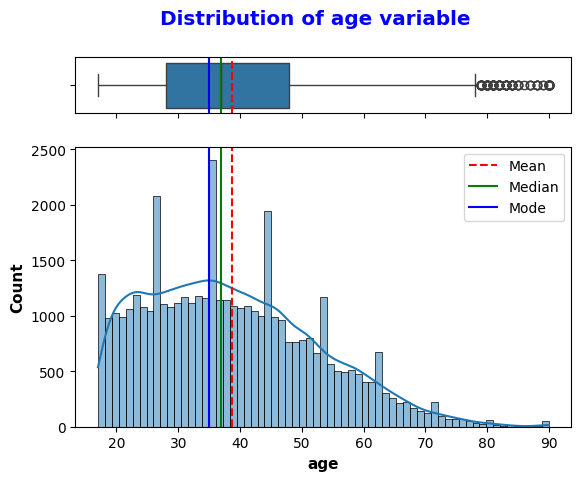

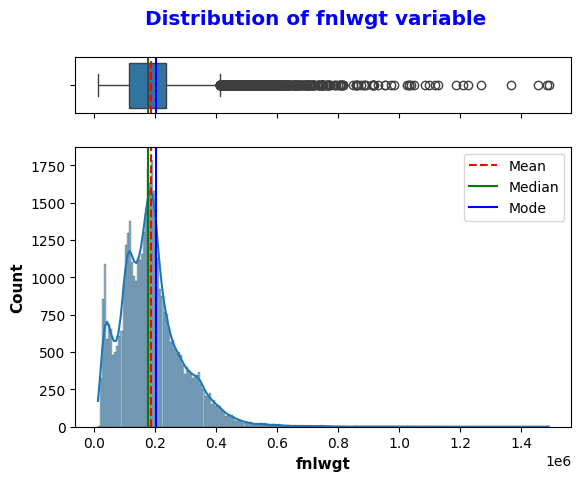

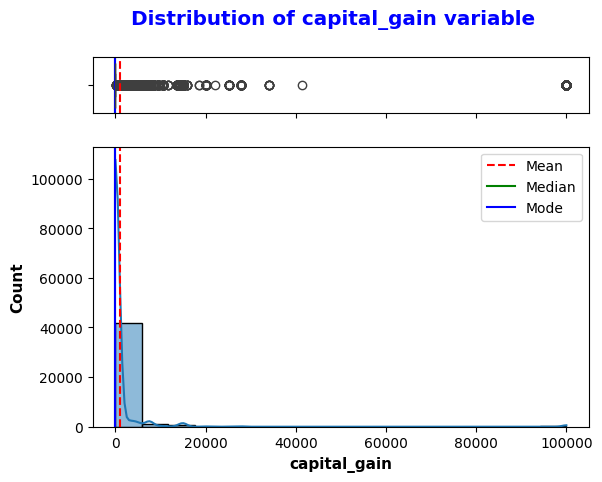

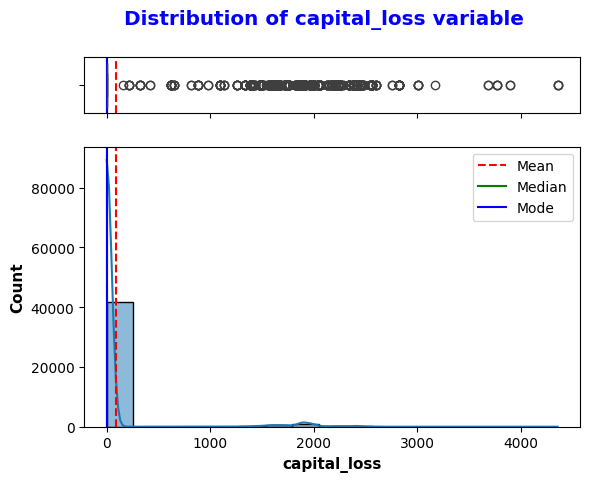

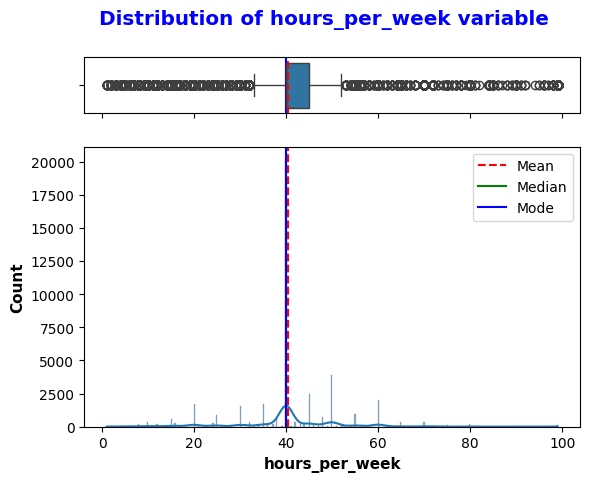

In [157]:
for col in num_cols:
    hist_box_plot(df, col)

#### "Logged" Distributions

In [158]:
df_log = pd.DataFrame()

for col in num_cols:
    df_log[f"log1_{col}"] = df[col].apply(np.log1p)

df_log

,log1_age,log1_fnlwgt,log1_capital_gain,log1_capital_loss,log1_hours_per_week
0,3.688879,11.258253,7.684784,0.0,3.713572
1,3.931826,11.330348,0.000000,0.0,2.639057
2,3.663562,12.281398,0.000000,0.0,3.713572
3,3.988984,12.366157,0.000000,0.0,3.713572
4,3.637586,12.558780,0.000000,0.0,3.713572
...,...,...,...,...,...
43827,3.688879,12.280345,0.000000,0.0,3.610918
43828,4.174387,12.680454,0.000000,0.0,3.713572
43829,3.663562,12.834639,0.000000,0.0,3.931826
43830,3.806662,11.337286,8.604471,0.0,3.713572


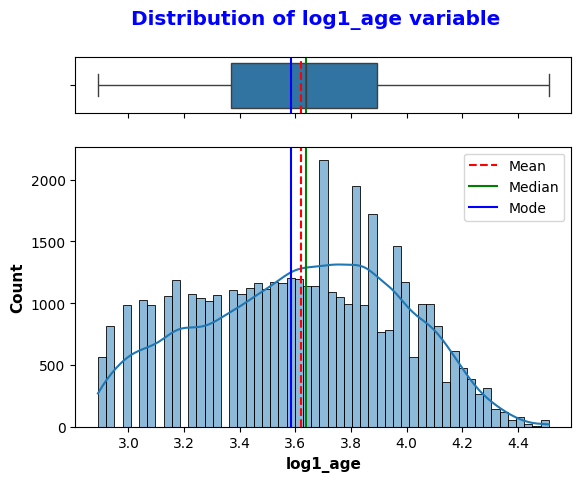

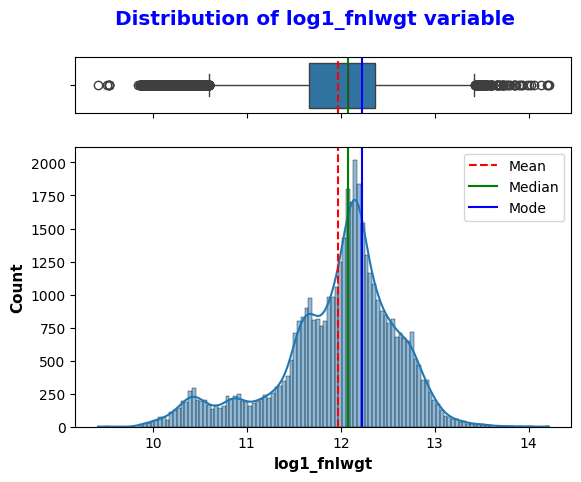

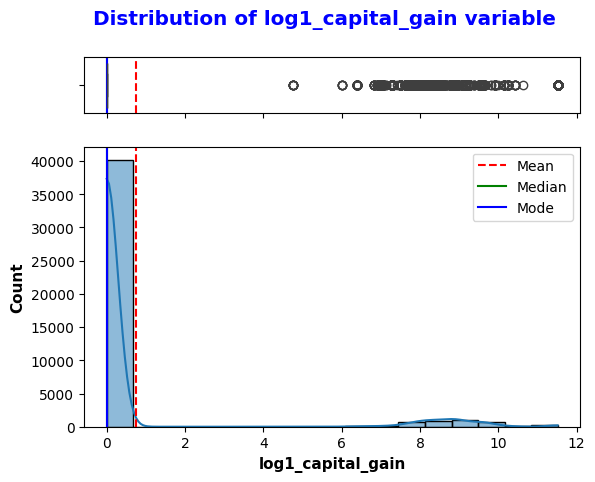

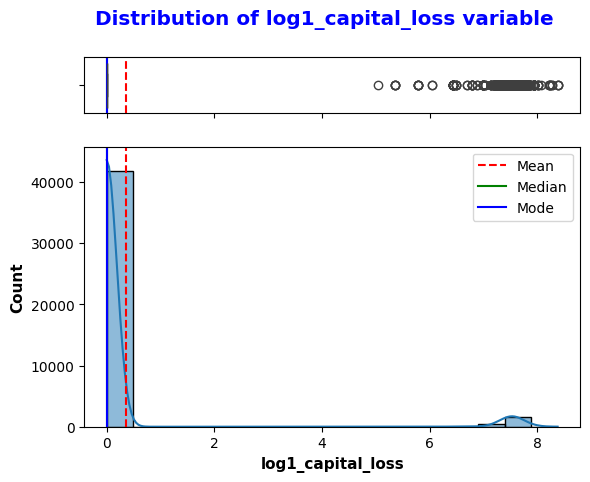

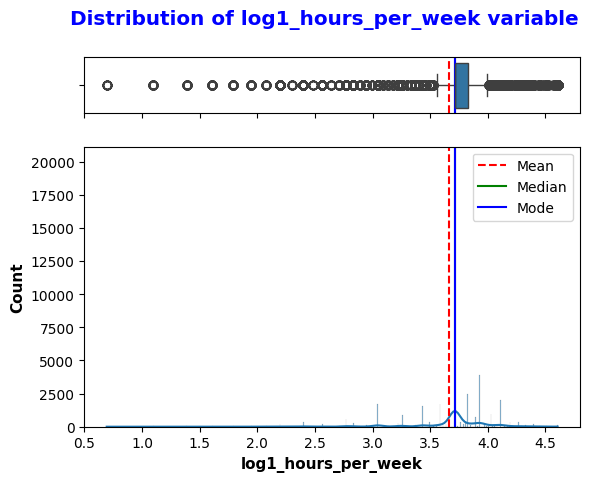

In [159]:
for col in df_log.columns:
    hist_box_plot(df_log, col)

#### *"rooted"* distributions

In [160]:
df_sqr = pd.DataFrame()

for col in num_cols:
    df_sqr[f"sqr_{col}"] = df[col].apply(np.sqrt)

df_sqr

,sqr_age,sqr_fnlwgt,sqr_capital_gain,sqr_capital_loss,sqr_hours_per_week
0,6.244998,278.416954,46.626173,0.0,6.324555
1,7.071068,288.636450,0.000000,0.0,3.605551
2,6.164414,464.377002,0.000000,0.0,6.324555
3,7.280110,484.480134,0.000000,0.0,6.324555
4,6.082763,533.462276,0.000000,0.0,6.324555
...,...,...,...,...,...
43827,6.244998,464.132524,0.000000,0.0,6.000000
43828,8.000000,566.924157,0.000000,0.0,6.324555
43829,6.164414,612.358555,0.000000,0.0,7.071068
43830,6.633250,289.639431,73.857972,0.0,6.324555


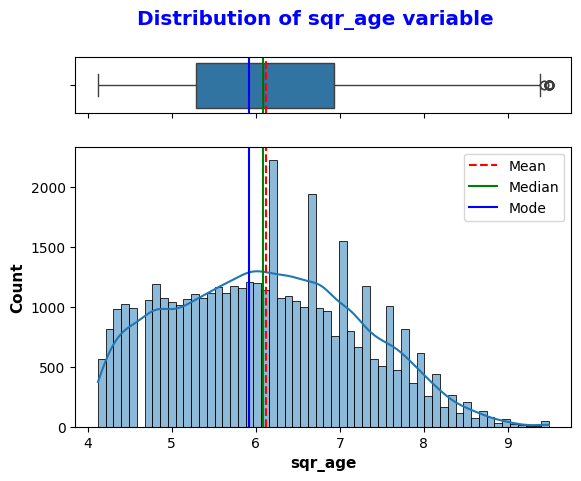

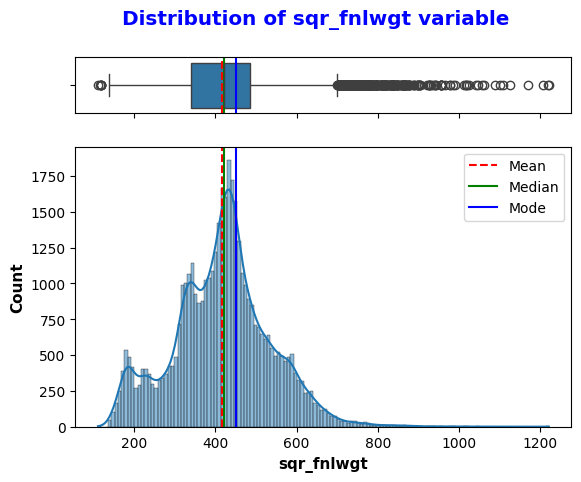

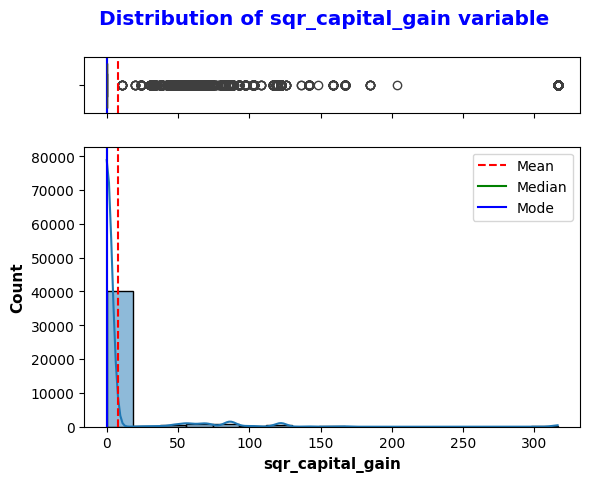

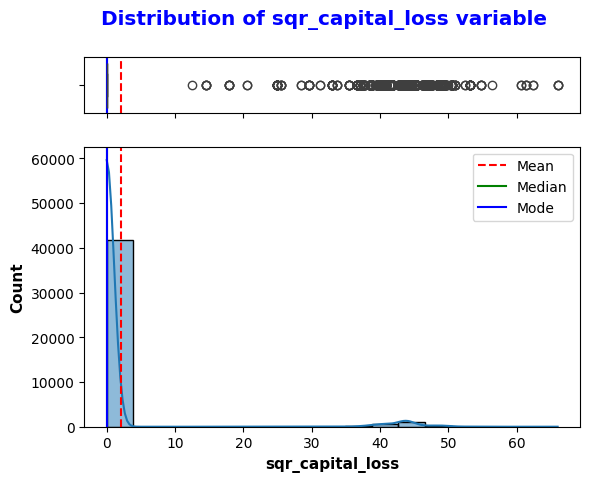

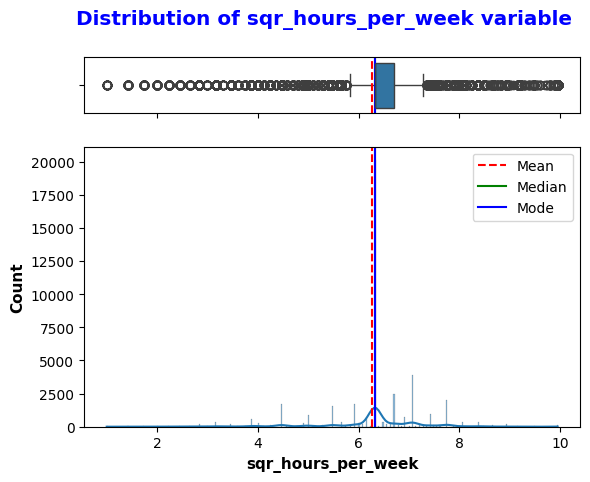

In [161]:
for col in df_sqr.columns:
    hist_box_plot(df_sqr, col)

#### Studying Some Variables More Precisely

In [162]:
df.hours_per_week.describe()

count    43832.000000
mean        40.440774
std         12.471352
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours_per_week, dtype: float64

In [163]:
df.hours_per_week.unique()

array([40., 13., 45., 50., 80., 30., 35., 60., 20., 52., 44., 15., 25.,
       43., 38., 55., 48., 58., 32., 70.,  2., 22., 56., 41., 28., 36.,
       24., 46., 42., 16., 12., 65.,  1., 10., 34., 98., 33., 54.,  8.,
        6., 64., 19., 18.,  5.,  9., 47., 37., 21., 26., 14.,  4., 72.,
        7., 99., 75., 53., 39., 62., 59., 57., 90., 66., 11., 49., 84.,
        3., 17., 68., 27., 85., 31., 78., 51., 63., 23., 87., 88., 73.,
       89., 97., 94., 29., 77., 96., 67., 82., 86., 91., 81., 76., 92.,
       61., 74., 95., 79.])

In [164]:
df.capital_loss.describe()

count    43832.000000
mean        88.789743
std        405.539243
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: capital_loss, dtype: float64

In [165]:
df.capital_loss.nunique()

97

In [166]:
df.capital_loss.value_counts()

capital_loss
0.0       41752
1902.0      277
1977.0      231
1887.0      216
1485.0       64
          ...  
3175.0        1
2467.0        1
155.0         1
2489.0        1
2163.0        1
Name: count, Length: 97, dtype: int64

In [167]:
df.capital_gain.describe()

count    43832.000000
mean      1089.626529
std       7455.791326
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital_gain, dtype: float64

In [168]:
df.capital_gain.value_counts()

capital_gain
0.0        40146
15024.0      465
7688.0       379
7298.0       335
99999.0      219
           ...  
22040.0        1
1111.0         1
7262.0         1
1731.0         1
6612.0         1
Name: count, Length: 123, dtype: int64

### Categorical Features

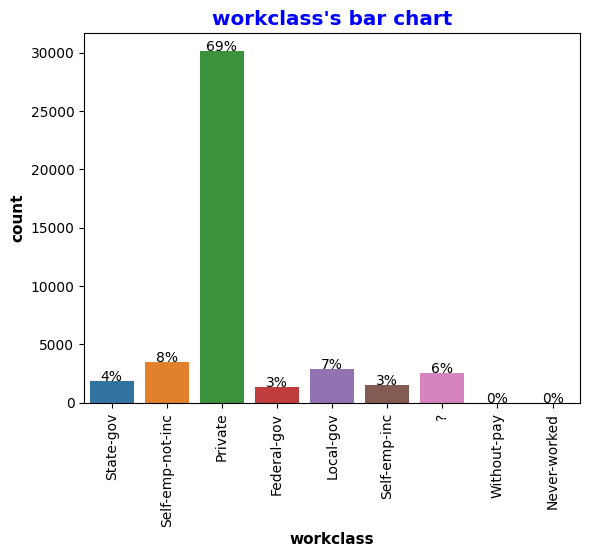

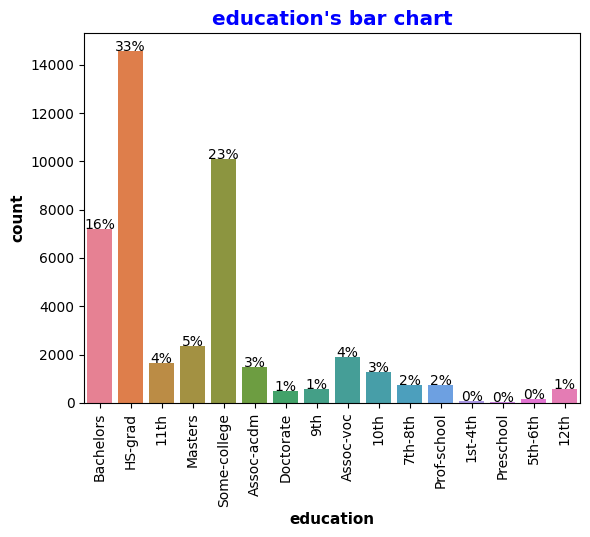

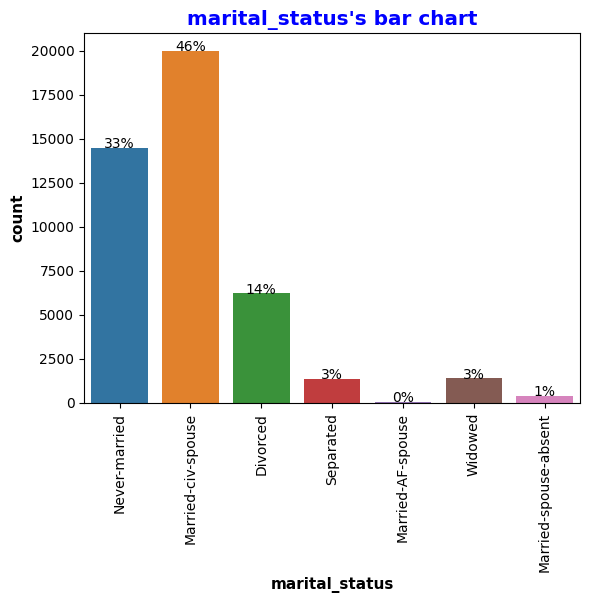

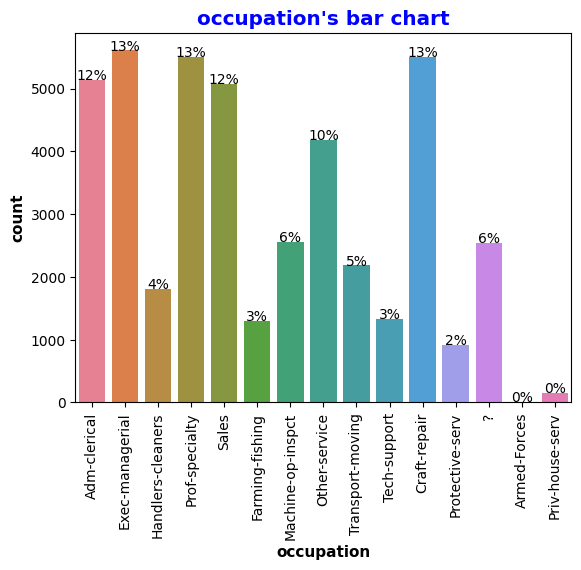

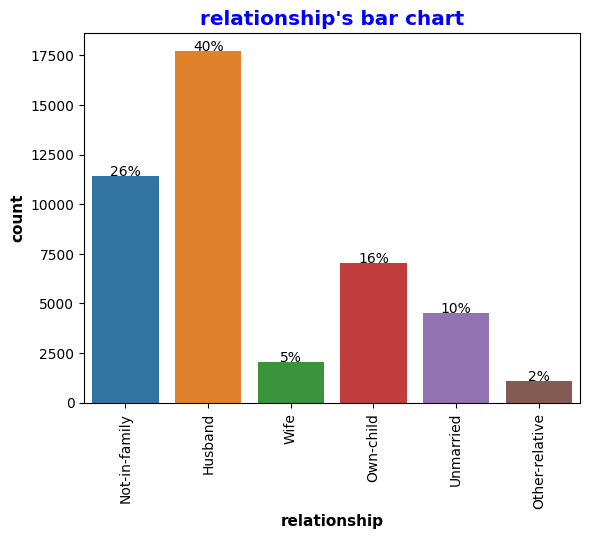

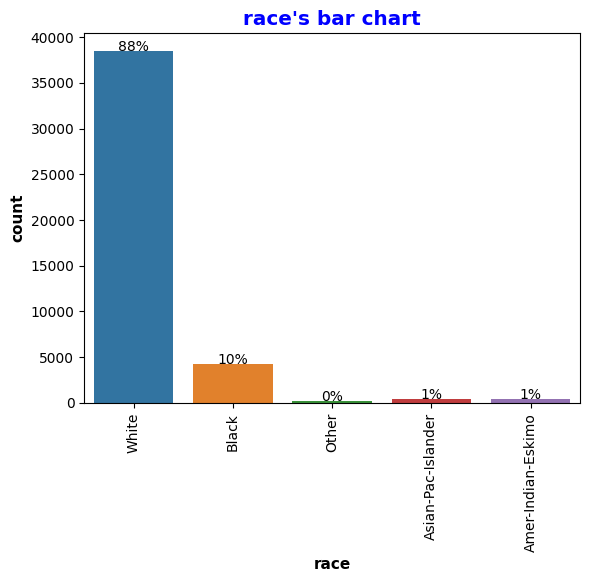

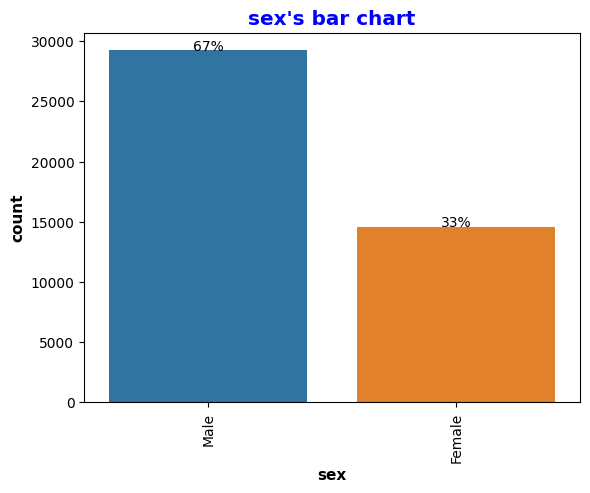

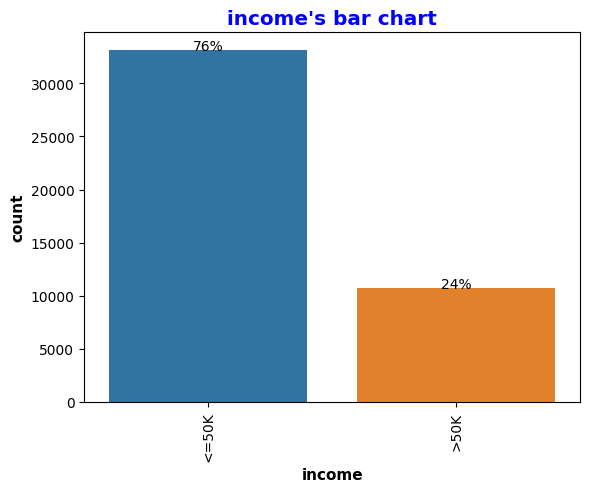

In [169]:
for col in cat_cols:
    bar_chart(df, col)

## Bivariate Analysis

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43832 entries, 0 to 43831
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             43832 non-null  int64  
 1   workclass       43832 non-null  object 
 2   fnlwgt          43832 non-null  float64
 3   education       43832 non-null  object 
 4   marital_status  43832 non-null  object 
 5   occupation      43832 non-null  object 
 6   relationship    43832 non-null  object 
 7   race            43832 non-null  object 
 8   sex             43832 non-null  object 
 9   capital_gain    43832 non-null  float64
 10  capital_loss    43832 non-null  float64
 11  hours_per_week  43832 non-null  float64
 12  income          43832 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usage: 4.3+ MB


## Numerical Variables

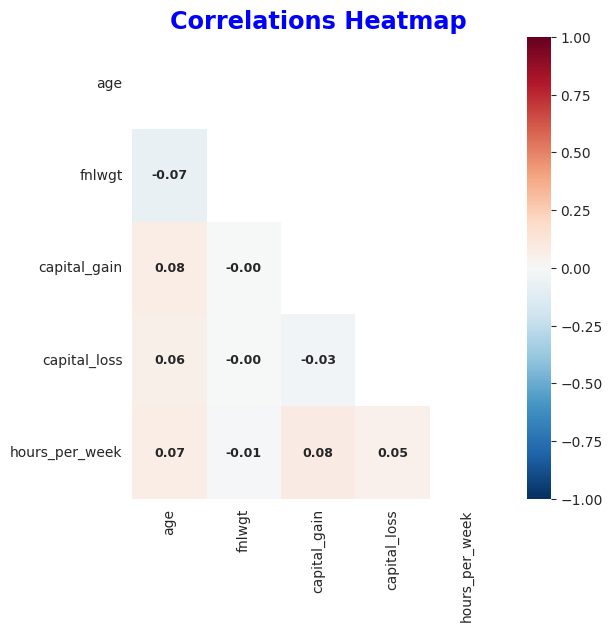

In [171]:
correlation_heatmap(df)

## Categorical Variables

In [172]:
# Statistical Threshold
alpha = 0.05

In [173]:
cat_cols

Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'income'],
      dtype='object')

In [174]:
cat_combinations = list(itertools.combinations(cat_cols[::-1], 2))
cat_combinations

[('income', 'sex'),
 ('income', 'race'),
 ('income', 'relationship'),
 ('income', 'occupation'),
 ('income', 'marital_status'),
 ('income', 'education'),
 ('income', 'workclass'),
 ('sex', 'race'),
 ('sex', 'relationship'),
 ('sex', 'occupation'),
 ('sex', 'marital_status'),
 ('sex', 'education'),
 ('sex', 'workclass'),
 ('race', 'relationship'),
 ('race', 'occupation'),
 ('race', 'marital_status'),
 ('race', 'education'),
 ('race', 'workclass'),
 ('relationship', 'occupation'),
 ('relationship', 'marital_status'),
 ('relationship', 'education'),
 ('relationship', 'workclass'),
 ('occupation', 'marital_status'),
 ('occupation', 'education'),
 ('occupation', 'workclass'),
 ('marital_status', 'education'),
 ('marital_status', 'workclass'),
 ('education', 'workclass')]

In [175]:
len(cat_combinations)

28

In [176]:
for idx, (var1, var2) in enumerate(cat_combinations, 1):
    ct = contingency_table(var1, var2, df)
    chi2, p, dof, expected = chi2_contingency(ct)

    if p < alpha:
        print(f"{idx}) Correlation between {var1} and {var2}, with {chi2=:.3f}")
    else:
        print(f"No correlation between {var1} and {var2}")

1) Correlation between income and sex, with chi2=2118.214
2) Correlation between income and race, with chi2=455.101
3) Correlation between income and relationship, with chi2=9343.697
4) Correlation between income and occupation, with chi2=5220.600
5) Correlation between income and marital_status, with chi2=9147.397
6) Correlation between income and education, with chi2=5742.309
7) Correlation between income and workclass, with chi2=1358.624
8) Correlation between sex and race, with chi2=628.036
9) Correlation between sex and relationship, with chi2=18399.586
10) Correlation between sex and occupation, with chi2=8096.471
11) Correlation between sex and marital_status, with chi2=9490.727
12) Correlation between sex and education, with chi2=377.590
13) Correlation between sex and workclass, with chi2=1060.618
14) Correlation between race and relationship, with chi2=1739.563
15) Correlation between race and occupation, with chi2=1137.164
16) Correlation between race and marital_status, wit

17) Correlation between race and education, with chi2=640.685
18) Correlation between race and workclass, with chi2=656.460
19) Correlation between relationship and occupation, with chi2=7284.007
20) Correlation between relationship and marital_status, with chi2=52774.293
21) Correlation between relationship and education, with chi2=3100.302
22) Correlation between relationship and workclass, with chi2=2264.086
23) Correlation between occupation and marital_status, with chi2=4866.332
24) Correlation between occupation and education, with chi2=20692.394
25) Correlation between occupation and workclass, with chi2=56766.969
26) Correlation between marital_status and education, with chi2=2063.548
27) Correlation between marital_status and workclass, with chi2=1955.393
28) Correlation between education and workclass, with chi2=3590.175


## Categorical VS Numerical

# Modeling

## Separate Features and Target

In [177]:
X = df.copy()
y = X.pop("income")
X

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week
0,39,State-gov,77516.0,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0
1,50,Self-emp-not-inc,83311.0,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0
2,38,Private,215646.0,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0
3,53,Private,234721.0,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0
4,37,Private,284582.0,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...
43827,39,Private,215419.0,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0
43828,64,?,321403.0,HS-grad,Widowed,?,Other-relative,Black,Male,0.0,0.0,40.0
43829,38,Private,374983.0,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0
43830,44,Private,83891.0,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0


In [178]:
y

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4        <=50K
         ...  
43827    <=50K
43828    <=50K
43829    <=50K
43830    <=50K
43831     >50K
Name: income, Length: 43832, dtype: object

## Hold-Out

In [179]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=69
)

## Encode Target

In [180]:
lab_enc = LabelEncoder()

In [181]:
y_train = lab_enc.fit_transform(y_train)
y_test = lab_enc.fit_transform(y_test)

In [182]:
num_cols

Index(['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week'], dtype='object')

In [183]:
cat_cols

Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'income'],
      dtype='object')

In [184]:
bin_feats = ['sex']
nom_feats = ['workclass', 'marital_status', 'occupation', 'relationship', 'race']
ord_feats = ['education']

In [185]:
ohe_nom = OneHotEncoder(drop="first", handle_unknown="ignore",
                        sparse_output=False)
ohe_bin = OneHotEncoder(drop="if_binary", handle_unknown="ignore",
                       sparse_output=False)

In [186]:
df.education.unique()

array(['Bachelors', 'HS-grad', '11th', 'Masters', 'Some-college',
       'Assoc-acdm', 'Doctorate', '9th', 'Assoc-voc', '10th', '7th-8th',
       'Prof-school', '1st-4th', 'Preschool', '5th-6th', '12th'],
      dtype=object)

In [187]:
educ_cats = [
    ["Preschool", "1st-4th", "5th-6th", "7th-8th", "9th", "10th",
    "11th", "12th", "HS-grad", "Some-college", "Assoc-voc", "Assoc-acdm",
    "Bachelors", "Masters", "Prof-school", "Doctorate"]
]

In [188]:
ord_enc = OrdinalEncoder(categories=educ_cats,
                         handle_unknown="use_encoded_value",
                         unknown_value=-1)

In [189]:
num_feats = num_cols
std_scl = StandardScaler()

In [190]:
preproc = ColumnTransformer(
    transformers = [
        ("bin", ohe_bin, bin_feats),
        ("nom", ohe_nom, nom_feats),
        ("ord", ord_enc, ord_feats),
        ("num", std_scl, num_feats)
    ],
    # remainder = "passthrough",
    verbose_feature_names_out = False
)

In [191]:
preproc

ColumnTransformer(transformers=[('bin',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['sex']),
                                ('nom',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['workclass', 'marital_status', 'occupation',
                                  'relationship', 'race']),
                                ('ord',
                                 OrdinalEncoder(categories=[['Preschool',
                                                             '1st-4th',
                                                             '5th-6th',
                                                             '7th-8th', '9th',
                                                             '10th', '11th',
                                                             '12th', 'HS-grad',
                                                             'Some-college',
                                                             'Assoc-voc',
                                                             'Assoc-acdm',
                                                             'Bachelors',
                                                             'Masters',
                                                             'Prof-school',
                                                             'Doctorate']],
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['education']),
                                ('num', StandardScaler(),
                                 Index(['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week'], dtype='object'))],
                  verbose_feature_names_out=False)

In [192]:
X_train_transf = preproc.fit_transform(X_train)
X_train_transf

,sex_Male,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital_status_Married-AF-spouse,...,race_Asian-Pac-Islander,race_Black,race_Other,race_White,education,age,fnlwgt,capital_gain,capital_loss,hours_per_week
27426,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,12.0,0.528911,-0.713115,-0.146613,-0.217775,0.764081
35610,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,6.0,-0.269555,-0.617672,-0.146613,-0.217775,-0.036166
27499,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,8.0,-1.068022,0.518158,-0.146613,-0.217775,-0.036166
43014,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,10.0,-0.342143,-0.119473,0.102040,-0.217775,-0.036166
20719,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,9.0,-0.777671,0.199447,-0.146613,-0.217775,-1.316561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,9.0,-0.342143,-0.329298,-0.146613,-0.217775,-0.436289
24533,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,8.0,0.093384,-0.931027,-0.146613,3.929056,-0.036166
29238,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,8.0,0.165972,-1.068022,-0.146613,-0.217775,0.764081
35402,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,8.0,0.819263,0.024239,0.844467,-0.217775,0.764081


## Feature Importance

In [193]:
rfc = RandomForestClassifier()
rfc.fit(X_train_transf, y_train)

RandomForestClassifier()

In [194]:
importances = rfc.feature_importances_
importances

array([1.42853504e-02, 4.76576497e-03, 5.26749533e-03, 1.86353832e-06,
       9.40797405e-03, 6.30736564e-03, 7.63312060e-03, 4.15068553e-03,
       9.97579988e-05, 3.27741887e-04, 9.84999700e-02, 9.88360649e-04,
       2.68668831e-02, 1.84759753e-03, 1.96418964e-03, 4.89112722e-03,
       1.12187196e-05, 5.68453850e-03, 2.22072654e-02, 4.21244767e-03,
       2.80996160e-03, 3.19267067e-03, 5.38076944e-03, 1.37212399e-04,
       1.69934529e-02, 2.86217512e-03, 6.22439461e-03, 4.40340738e-03,
       4.12004131e-03, 1.88466034e-02, 1.62243728e-03, 1.19835282e-02,
       7.44556772e-03, 8.17024994e-03, 1.62107409e-03, 4.24111035e-03,
       5.81614057e-04, 5.59473043e-03, 1.06893979e-01, 1.56807330e-01,
       1.81020709e-01, 1.10596718e-01, 3.36749283e-02, 8.53546166e-02])

In [195]:
indices = np.argsort(importances)[::-1]
indices

array([40, 39, 41, 38, 10, 43, 42, 12, 18, 29, 24,  0, 31,  4, 33,  6, 32,
        5, 26, 17, 37, 22,  2, 15,  1, 27, 35, 19,  7, 28, 21, 25, 20, 14,
       13, 30, 34, 11, 36,  9, 23,  8, 16,  3])

In [196]:
feat_labels = X_train_transf.columns
feat_labels

Index(['sex_Male', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital_status_Married-AF-spouse',
       'marital_status_Married-civ-spouse',
       'marital_status_Married-spouse-absent', 'marital_status_Never-married',
       'marital_status_Separated', 'marital_status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'relationship_Not-in-family', 'relationship_Other-relative',
       'relationship_Own

In [197]:
for f in range(X_train_transf.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 40,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

 1) fnlwgt                                   0.181021
 2) age                                      0.156807
 3) capital_gain                             0.110597
 4) education                                0.106894
 5) marital_status_Married-civ-spouse        0.098500
 6) hours_per_week                           0.085355
 7) capital_loss                             0.033675
 8) marital_status_Never-married             0.026867
 9) occupation_Exec-managerial               0.022207
10) relationship_Not-in-family               0.018847
11) occupation_Prof-specialty                0.016993
12) sex_Male                                 0.014285
13) relationship_Own-child                   0.011984
14) workclass_Private                        0.009408
15) relationship_Wife                        0.008170
16) workclass_Self-emp-not-inc               0.007633
17) relationship_Unmarried                   0.007446
18) workclass_Self-emp-inc                   0.006307
19) occupation_Sales        

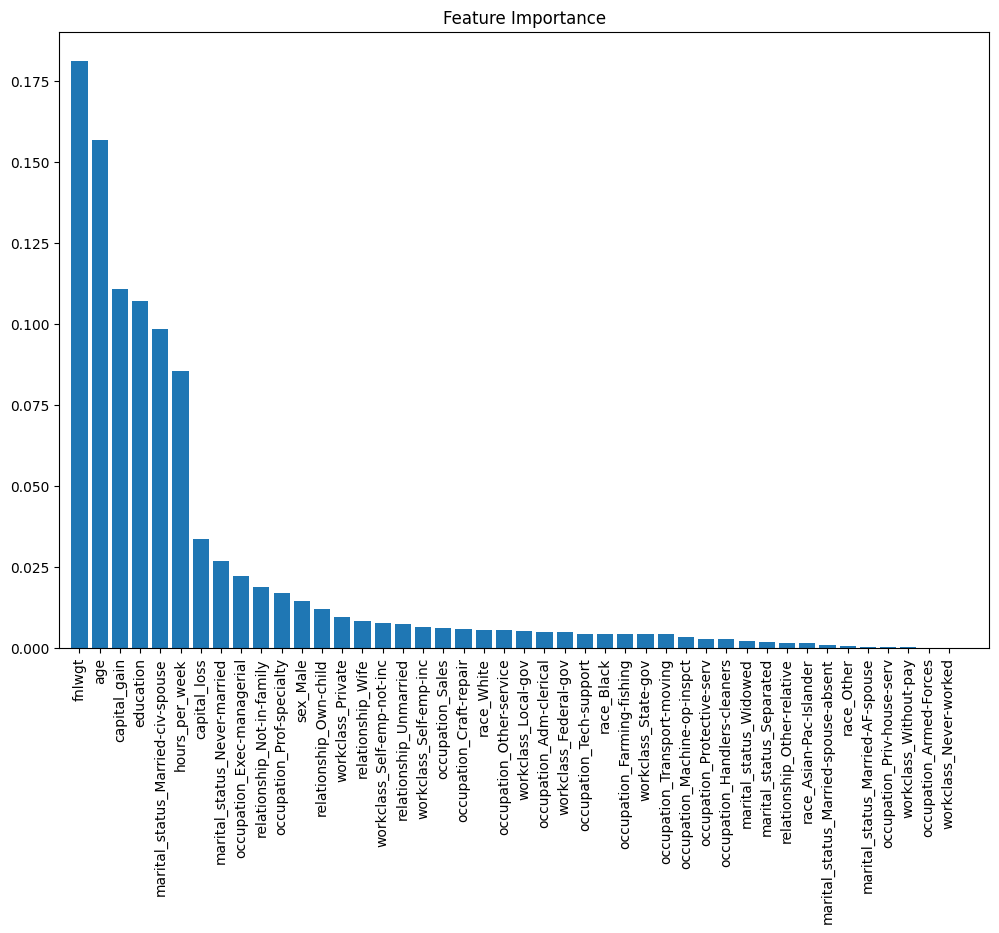

In [198]:
plt.figure(figsize=(12, 8))
plt.bar(range(X_train_transf.shape[1]),
        importances[indices],
        align='center')
plt.xticks(range(X_train_transf.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim(-1, X_train_transf.shape[1] + 1)
plt.title("Feature Importance")
# plt.tight_layout()
plt.show()

In [199]:
X_test_transf = preproc.transform(X_test)

In [200]:
rfc.score(X_test_transf, y_test)

0.8561651648226303

## Different Models

### Logistic Regression

In [201]:
pipe_logreg = make_pipeline(preproc, LogisticRegression())
pipe_logreg

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('nom',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['workclass',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['Prescho...
                                                                              'HS-grad',
                                                                              'Some-college',
                                                                              'Assoc-voc',
                                                                              'Assoc-acdm',
                                                                              'Bachelors',
                                                                              'Masters',
                                                                              'Prof-school',
                                                                              'Doctorate']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['education']),
                                                 ('num', StandardScaler(),
                                                  Index(['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('logisticregression', LogisticRegression())])

In [202]:
pipe_logreg.fit(X_train, y_train)
pipe_logreg.score(X_test, y_test)

/home/utilisateur/Bureau/Projets/ML_avance/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8480666134367515

### KNN

In [204]:
pipe_knc = make_pipeline(preproc, KNeighborsClassifier())
pipe_knc

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('bin',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex']),
                                                 ('nom',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['workclass',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race']),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['Prescho...
                                                                              'Some-college',
                                                                              'Assoc-voc',
                                                                              'Assoc-acdm',
                                                                              'Bachelors',
                                                                              'Masters',
                                                                              'Prof-school',
                                                                              'Doctorate']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['education']),
                                                 ('num', StandardScaler(),
                                                  Index(['age', 'fnlwgt', 'capital_gain', 'capital_loss', 'hours_per_week'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [205]:
pipe_knc.fit(X_train, y_train)
pipe_knc.score(X_test, y_test)

0.8312991901448614

/home/utilisateur/Bureau/Projets/ML_avance/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utilisateur/Bureau/Projets/ML_avance/ml/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:228: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/utilisateur/Bureau/Projets/ML_avance/ml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATI

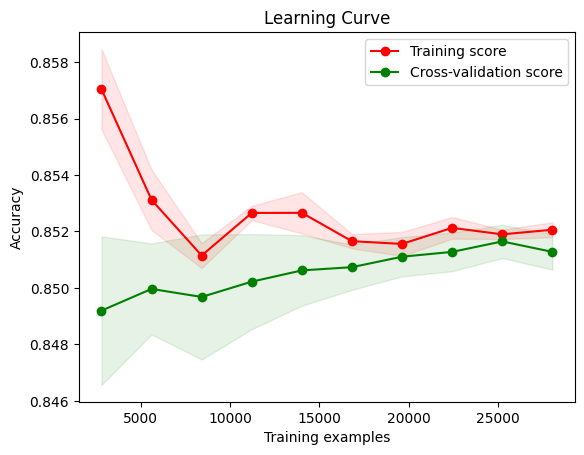

In [206]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = pipe_logreg,
    X = X_train,
    y = y_train,
    train_sizes = np.linspace(0.1, 1.0, 10),
    cv = 5,
    scoring = 'accuracy'
)

train_scores_mean = train_scores.mean(axis = 1)
train_scores_std = train_scores.std(axis = 1)
validation_scores_mean = validation_scores.mean(axis = 1)
validation_scores_std = validation_scores.std(axis = 1)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")

plt.legend(loc="best")
plt.show()

plt.show()

# AutoML?

In [207]:
# X_train_transf

In [208]:
# tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=69)
# tpot.fit(X_train_transf, y_train)